# Project #3

## Team members:
- Didi Ramsaran-Chin
- Victor Pietrini
- Kevin Fernandez
- Luis Fernando Díaz

## Supervisor
Dr Pedro García

## Is there a relation between diferentiated zones in a laberint and diferentiated zones of a Q matriz?

### 1. Generate four laberints ranging from regular to randomly connected using the recabling parameter.
### 2. Set "few" connections between laberints, to obtain one big laberint.
### 3. Solve the laberint composed by the four initial laberints, storing the resultant Q matrix.
### 4. Can we stablish any relationship between zones of the Q matrix and zones of the Laberints?    

## Libreries

In [205]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
from scipy.sparse import block_diag
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm import tqdm
import random

## Functions

In [206]:
# Function to validate that all nodes within a graph have at least one neighbour.
# Traverses node by node, creating a list of the neighbours of each node, in the event that
# an empty neighbours list is generated for any node, the function returns False
# otherwise, it returns True

def graph_validator(graph):
    nodes = list(graph.nodes)
    validGraph = True
    for node in nodes:
        nodeNeighbors = list(graph.neighbors(node))
        if not nodeNeighbors or not nx.is_connected(graph):
            validGraph = False
    return validGraph

In [207]:
# Graphs union function
def supergraph_generator(G1, G2, G3, G4):
    supergraph = nx.disjoint_union(G1, G2)
    supergraph = nx.disjoint_union(supergraph, G3)
    supergraph = nx.disjoint_union(supergraph, G4)
    return supergraph

In [208]:
# Subgraph bridging funtion

def bridge_generator(M1, nodes):
    M1Nodes = list(M1.nodes)
    sub1 = M1Nodes[0:nodes]
    sub2 = M1Nodes[nodes:nodes*2]
    sub3 = M1Nodes[nodes*2:nodes*3]
    sub4 = M1Nodes[nodes*3:nodes*4]

    subgraphs = [sub1, sub2, sub3, sub4]
    M2 = M1
    bridge_nodes = []

    # Subgraph connector 1 and 2
    node1 = random.choice(sub1)
    node2 = random.choice(sub2)
    M2.add_edge(node1, node2)
    bridge_nodes.append(node1)

    # Subgraph connector 2 and 3
    node1 = random.choice(sub2)
    node2 = random.choice(sub3)
    M2.add_edge(node1, node2)
    bridge_nodes.append(node1)

    # Subgraph connector 3 and 4
    node1 = random.choice(sub3)
    node2 = random.choice(sub4)
    M2.add_edge(node1, node2)
    bridge_nodes.append(node1)

    return M2, bridge_nodes

In [209]:
# Subgraphs generating function
def generate_maze(size, rewiring_prob):
    graph = nx.watts_strogatz_graph(size, k=round(size/2), p=rewiring_prob)
    while not graph_validator(graph):
        graph = nx.watts_strogatz_graph(size, k=round(size/2), p=rewiring_prob)
    return graph

In [210]:
def update(Q, state, action, reward, next_state, alpha, gamma):
    current_q = Q[state, action]
    max_next_q = np.max(Q[next_state])
    updated_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
    Q[state, action] = updated_q
    return updated_q

In [211]:
# Q-Learning RL algorithm
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.num_states, env.num_actions))
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space_sample()
            else:
                action = np.argmax(Q[state])
            next_state, reward, done, _ = env.step(action)
            update(Q, state, action, reward, next_state, alpha, gamma)
            state = next_state
    return Q

In [212]:
# Jaccard similarity
def jaccard_similarity(graph1, graph2):
    edges1 = set(graph1.edges)
    edges2 = set(graph2.edges)
    intersection = len(edges1.intersection(edges2))
    union = len(edges1.union(edges2))
    return intersection / union if union != 0 else 0

## Maze creation

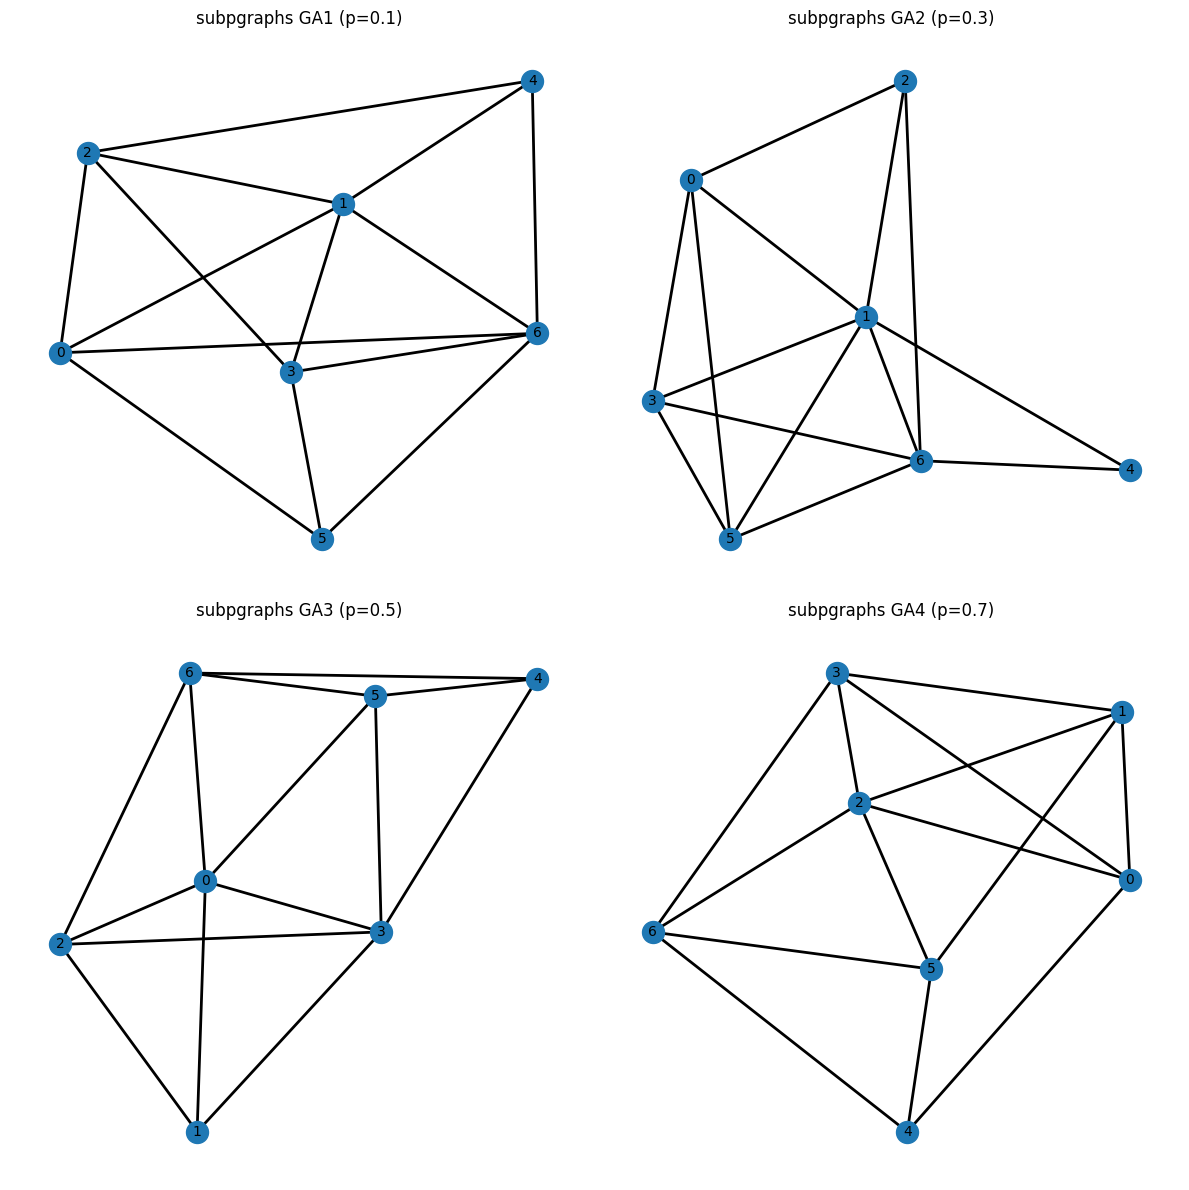

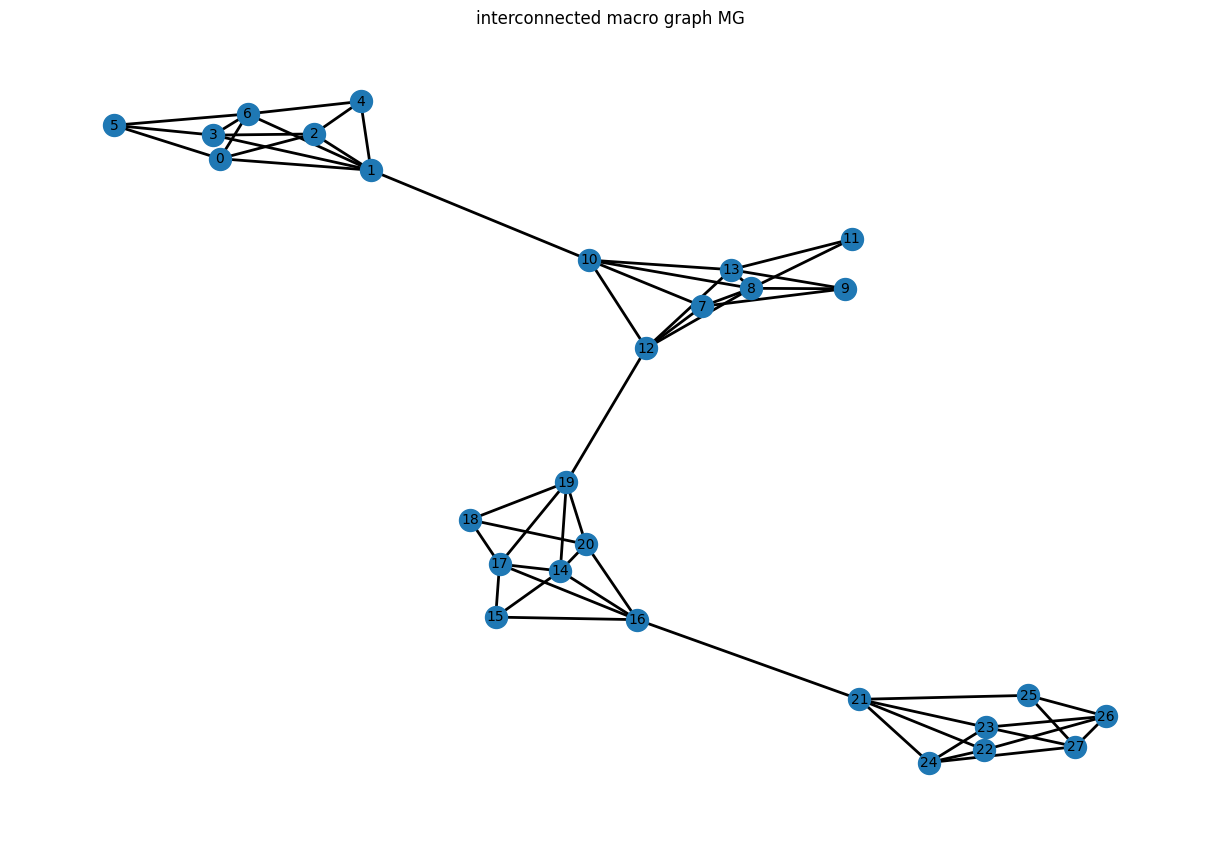

In [213]:
N = 7

# Generando laberintos
mazes = [generate_maze(N, p) for p in [0.1, 0.3, 0.5, 0.7]]

# Visualizando los laberintos
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
titles = ['subpgraphs GA1 (p=0.1)', 'subpgraphs GA2 (p=0.3)', 'subpgraphs GA3 (p=0.5)', 'subpgraphs GA4 (p=0.7)']

for ax, maze, title in zip(axes, mazes, titles):
    pos = nx.spring_layout(maze)
    nx.draw(maze, pos, ax=ax, with_labels=True, node_size=250, font_size=10, width=2)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# Creando el supergrafo
supergraph = supergraph_generator(*mazes)

# Crear puentes entre los subgrafos
supergraph_connected, bridge_nodes = bridge_generator(supergraph, nodes=N)

# Visualización
options = {'node_size': 250, 'font_size': 10, 'width': 2}
pos = nx.spring_layout(supergraph_connected)
plt.figure(figsize=(12, 8))
nx.draw(supergraph_connected, pos=pos, with_labels=True, **options)
plt.title('interconnected macro graph MG')
plt.show()


## Maze Enviroment Class

In [214]:
class MazeEnv:
    def __init__(self, graph, sub1_nodes, sub4_nodes, bridge_nodes):
        self.graph = graph
        self.num_states = len(graph.nodes)
        self.num_actions = len(graph.nodes)
        self.state = None
        self.sub1_nodes = sub1_nodes
        self.sub4_nodes = sub4_nodes
        self.bridge_nodes = bridge_nodes
        self.goal_state = self.set_goal()

    def set_goal(self):
        possible_goal_nodes = list(set(self.sub4_nodes) - set(self.bridge_nodes))
        return random.choice(possible_goal_nodes)

    def reset(self):
        possible_start_nodes = list(set(self.sub1_nodes) - set(self.bridge_nodes))
        self.state = random.choice(possible_start_nodes)
        return self.state

    def step(self, action):
        if action in self.graph[self.state]:
            next_state = action
            reward = -1  # Recompenzar por movimientos válidos
            done = False
            if next_state == self.goal_state:  # Estado meta es un nodo específico
                reward = 100
                done = True
        else:
            next_state = self.state
            reward = -10  # Penalizar por movimientos inválidos
            done = False
        self.state = next_state
        return next_state, reward, done, {}

    def action_space_sample(self):
        return random.choice(list(self.graph.nodes))

## Implementation of Q-learning algorithm

In [215]:
# Instancia el ambiente con el supergrafo conectado
sub1_nodes = list(range(N))      # nodos para el subgrafo 1
sub4_nodes = list(range(N*3, N*4))  # nodos para el subgrafo 4
maze_env = MazeEnv(supergraph_connected, sub1_nodes=sub1_nodes, sub4_nodes=sub4_nodes, bridge_nodes=bridge_nodes)

# Execution of the Q-Learning algorithm
num_episodes = 1000
alpha = 0.1
gamma = 0.9
epsilon = 0.1

Q = q_learning(maze_env, num_episodes, alpha, gamma, epsilon)

#print("Q-matrix:")
#print(pd.DataFrame(Q))

# Similarity calculation between matrices Ai in M
similarity_results = []

for i in range(4):
    for j in range(i+1, 4):
        similarity = jaccard_similarity(mazes[i], mazes[j]) # similarity metric function
        similarity_results.append((f"Laberinto {i+1} vs Laberinto {j+1}", similarity))

# Muestra los resultados
similarity_df = pd.DataFrame(similarity_results, columns=["Comparación", "Similaridad"])
print("Similaridad entre laberintos")
print(similarity_df)

# Start matrices to extract qi from Q
np.zeros
q_1 = np.zeros((N, N))
q_2 = np.zeros((N, N))
q_3 = np.zeros((N, N))
q_4 = np.zeros((N, N))

# we extract q1 from Q
for i in range(0, N, 1):
  for j in range(0, N, 1):
    q_1[i,j] = Q[i,j]
#print("Esta es la matriz q1: ",q_1)

# we extract q2 from Q
for i in range(N, (2*N), 1):
    for j in range(N, (2*N), 1):
      q_2[i-N,j-N] = Q[i,j]
#print("Esta es la matriz q2: ",q_2)

# we extract q3 from Q
for i in range(2*N, (3*N), 1):
    for j in range(2*N, (3*N), 1):
      q_3[i-N*2,j-N*2] = Q[i,j]
#print("Esta es la matriz q3: ",q_3)

# we extract q4 from Q
for i in range(3*N, (4*N), 1):
    for j in range(3*N, (4*N), 1):
      q_4[i-N*3,j-N*3] = Q[i,j]
#print("Esta es la matriz q4: ",q_4)

# qi submatrices are stored in a list for easy managenment
q_submatrices = [q_1, q_2, q_3, q_4]


# Similarity calculation between matrices qi in Q
similarity_q_results = []

for i in range(len(q_submatrices)):
    for j in range(i+1, len(q_submatrices)):
        similarity = jaccard_similarity(nx.from_numpy_array(q_submatrices[i]), nx.from_numpy_array(q_submatrices[j])) # similarity metric function for qi
        similarity_q_results.append((f"Q-submatriz {i+1} vs Q-submatriz {j+1}", similarity))

# Q-submatricies similarity results desplaying
similarity_q_df = pd.DataFrame(similarity_q_results, columns=["Comparación", "Similaridad"])
print("Similaridad entre Q-submatrices:")
print(similarity_q_df)

# Similarity between correspondent qi (learning) and Ai matrices (environment)
maze_q_similarity_results = []

for i, maze in enumerate(mazes):
    maze_adj = nx.adjacency_matrix(maze).todense()
    for j, q_submatrix in enumerate(q_submatrices):
        similarity = jaccard_similarity(nx.from_numpy_array(np.array(maze_adj)), nx.from_numpy_array(q_submatrix))
        maze_q_similarity_results.append((f"Laberinto {i+1} vs Q-submatriz {j+1}", similarity))

# Q-submatricies against laberinth similarity results desplaying
maze_q_similarity_df = pd.DataFrame(maze_q_similarity_results, columns=["Comparación", "Similaridad"])
print("Similaridad entre Laberintos y Q-Submatrices:")
print(maze_q_similarity_df)

Similaridad entre laberintos
                  Comparación  Similaridad
0  Laberinto 1 vs Laberinto 2     0.647059
1  Laberinto 1 vs Laberinto 3     0.555556
2  Laberinto 1 vs Laberinto 4     0.400000
3  Laberinto 2 vs Laberinto 3     0.555556
4  Laberinto 2 vs Laberinto 4     0.555556
5  Laberinto 3 vs Laberinto 4     0.555556
Similaridad entre Q-submatrices:
                      Comparación  Similaridad
0  Q-submatriz 1 vs Q-submatriz 2     1.000000
1  Q-submatriz 1 vs Q-submatriz 3     1.000000
2  Q-submatriz 1 vs Q-submatriz 4     0.857143
3  Q-submatriz 2 vs Q-submatriz 3     1.000000
4  Q-submatriz 2 vs Q-submatriz 4     0.857143
5  Q-submatriz 3 vs Q-submatriz 4     0.857143
Similaridad entre Laberintos y Q-Submatrices:
                     Comparación  Similaridad
0   Laberinto 1 vs Q-submatriz 1     0.500000
1   Laberinto 1 vs Q-submatriz 2     0.500000
2   Laberinto 1 vs Q-submatriz 3     0.500000
3   Laberinto 1 vs Q-submatriz 4     0.461538
4   Laberinto 2 vs Q-submatriz 1

In [216]:
# subgraohs Gqi created based on submatrices qi
Gq1 = nx.Graph()
Gq2 = nx.Graph()
Gq3 = nx.Graph()
Gq4 = nx.Graph()


column_value = 0
for column in q_1:
  row_value = 0
  for row in column:
    if row > 0:
      Gq1.add_edge((row_value), (column_value))
    row_value += 1
  column_value += 1

column_value = 0
for column in q_2:
  row_value = 0
  for row in column:
    if row > 0:
      Gq2.add_edge((row_value), (column_value))
    row_value += 1
  column_value += 1

column_value = 0
for column in q_3:
  row_value = 0
  for row in column:
    if row > 0:
      Gq3.add_edge((row_value), (column_value))
    row_value += 1
  column_value += 1

column_value = 0
for column in q_4:
  row_value = 0
  for row in column:
    if row > 0:
      Gq4.add_edge((row_value), (column_value))
    row_value += 1
  column_value += 1



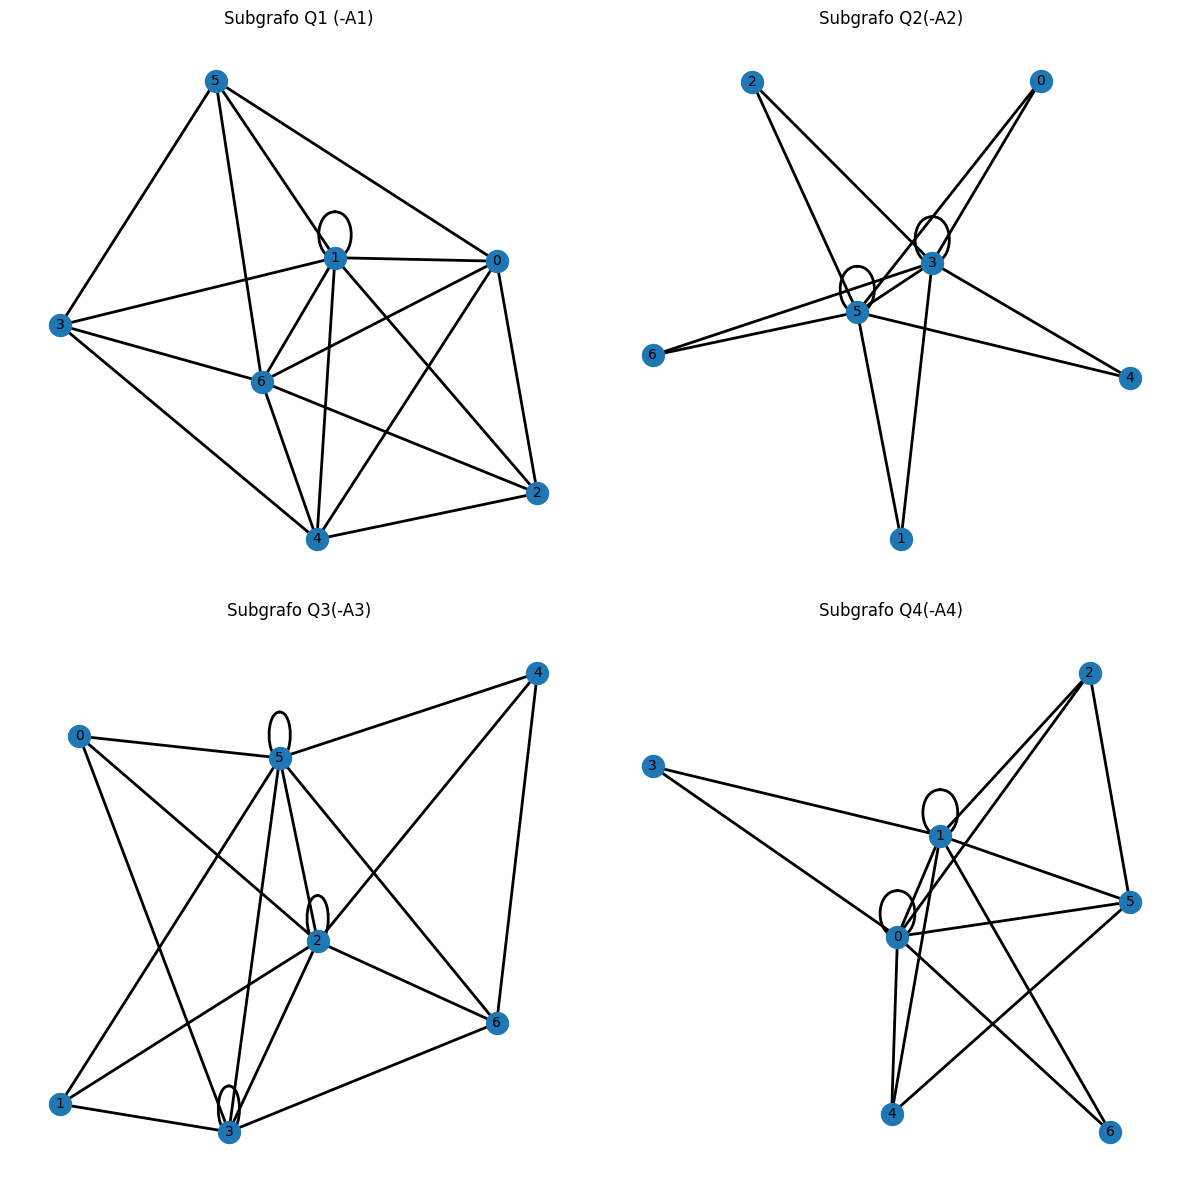

In [217]:
# printing of Gqi subgraphs

# lisnting
subgrafos = [Gq1, Gq2, Gq3, Gq4]

# visualizing
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
titles = ['Subgrafo Q1 (-A1)', 'Subgrafo Q2(-A2)', 'Subgrafo Q3(-A3)', 'Subgrafo Q4(-A4)']

for ax, subgrafos, title in zip(axes, subgrafos, titles):
    pos = nx.spring_layout(subgrafos)
    nx.draw(subgrafos, pos, ax=ax, with_labels=True, node_size=250, font_size=10, width=2)
    ax.set_title(title)

plt.tight_layout()
plt.show()


## Measuring intergraph similarity

In [218]:
# similarity calculation between graphs with optimal_edit_distance

# Gq1 and A1 (low rewiring coef)
paths, cost = nx.optimal_edit_paths(Gq1, mazes[0])
print("recableado bajo")
print(f"el número de posibles ediciones para mapear Gq1 a A1 es {len(paths)}")
print(f"el costo mínimo de conexiones entre nodos para pasar de Gq1 a A1 es {cost}")
print("")

# Gq2 and A2 (medium low rewiring coef)
paths, cost = nx.optimal_edit_paths(Gq2, mazes[1])
print("recableado medio bajo")
print(f"el número de posibles ediciones para mapear Gq2 a A2 es {len(paths)}")
print(f"el costo mínimo de conexiones entre nodos para pasar de Gq2 a A2 es {cost}")
print("")

# Gq3 and A3 (medium high rewiring coef)
paths, cost = nx.optimal_edit_paths(Gq3, mazes[2])
print("recableado medio alto")
print(f"el número de posibles ediciones para mapear Gq3 a A3 es {len(paths)}")
print(f"el costo mínimo de conexiones entre nodos para pasar de Gq3 a A3 es {cost}")
print("")

# Gq4 and A4 (high rewiring coef)
paths, cost = nx.optimal_edit_paths(Gq4, mazes[3])
print("recableado alto")
print(f"el número de posibles ediciones para mapear Gq4 a A4 es {len(paths)}")
print(f"el costo mínimo de conexiones entre nodos para pasar de Gq4 a A4 es {cost}")
print("")



recableado bajo
el número de posibles ediciones para mapear Gq1 a A1 es 24
el costo mínimo de conexiones entre nodos para pasar de Gq1 a A1 es 4.0

recableado medio bajo
el número de posibles ediciones para mapear Gq2 a A2 es 240
el costo mínimo de conexiones entre nodos para pasar de Gq2 a A2 es 7.0

recableado medio alto
el número de posibles ediciones para mapear Gq3 a A3 es 32
el costo mínimo de conexiones entre nodos para pasar de Gq3 a A3 es 6.0

recableado alto
el número de posibles ediciones para mapear Gq4 a A4 es 736
el costo mínimo de conexiones entre nodos para pasar de Gq4 a A4 es 9.0



In [219]:
# this is the recomended measure, but it can become slow when nodes number increases

print("edit distance Gq1 to A1 (low rewiring coef)", nx.graph_edit_distance(Gq1, mazes[0]))
print("edit distance Gq2 to A2 (medium low rewiring coef)", nx.graph_edit_distance(Gq2, mazes[1]))
print("edit distance Gq3 to A3 (medium high rewiring coef)", nx.graph_edit_distance(Gq3, mazes[2]))
print("edit distance Gq4 to A4 (high rewiring coef)", nx.graph_edit_distance(Gq4, mazes[3]))

edit distance Gq1 to A1 (low rewiring coef) 4.0
edit distance Gq2 to A2 (medium low rewiring coef) 7.0
edit distance Gq3 to A3 (medium high rewiring coef) 6.0
edit distance Gq4 to A4 (high rewiring coef) 9.0


## Resultados importantes

1. Parece ser que menor recableado es contingente a mayor cantidad de posibles modificaciones de la matriz q al laberinto original. Esto puede indicar que si la  ideosincracia del aprendizaje es menor, hay mayores maneras de recrear el amiente objetivo que sirvió de base para el entrenamiento (coste mayor)
2. Por el contrario, mayor singularidad, asumida en el mayor recableado, muestra menores posibles modificaciones de la experiencia para recrear el amniente objetivo, indicando una mayor similaridad (coste menor)
3. Sería ideal variar y registrar varias ejecuciones del algoritmo, para evaluar una distribución de manera más certera. Además, se podría estudiar en relación a otros parámetros (# nodos, continuidad en el parámetro de recableado, número de conexiones intre laberintos, etc).
  